## Install dependencies

In [2]:
#!pip install git+https://github.com/jthermiz/nma_timely_tigers --quiet
from nma_timely_tigers import utils, models
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd

In [3]:
from importlib import reload
reload(utils)

<module 'nma_timely_tigers.utils' from '/home/jhermiz/projects/nma_timely_tigers/nma_timely_tigers/utils.py'>

In [4]:
%matplotlib inline

## Load dataset

In [5]:
alldat = utils.load_steinmetz_dataset() # note this takes a bit bc it downloads data

Loading data from disk


## Fixed parameters

In [6]:
p = {}
p['start_time'] = 0.5
p['end_time'] = 1.2
p['exp_name'] = 'neuron_correlations'

## Sweep parameter(s)

In [7]:
s = {}
s['areas'] = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]
s['areas'] = [x for y in s['areas'] for x in y] #flatten

## Main loop

In [37]:
results = []
for session, dat in enumerate(alldat[:]):
    print(session)
    #for area in s['areas']:
    for area in s['areas']:
        for correct in [False, True]:
            spks, _ = utils.get_neurons_by_brain_area(dat, areas=area)   
            y = utils.animal_correctness_labels(dat)
            X = utils.average_trials_across_time(spks, 
                                                start_time=p['start_time'],
                                                end_time=p['end_time'],
                                                fs=100).T                
            if correct:
                X = X[y==1]
            else:
                X = X[y==0]
            
            # make X well conditioned
            X = X + 1e-4*np.random.randn(*X.shape)
            
            # have at least 11 trials and 2 neurons
            if (X.shape[0] > 10) and (X.shape[1] > 1):
                corrs = utils.calc_correlations(X.T)
                corr_mean, corr_mean_abs = np.mean(corrs), np.mean(np.abs(corrs))
                corr_median = np.median(corrs)
                result = {'session': session, list(s.keys())[0]: area, 
                          'correct': correct, 'corr_values': corrs, 
                          'corr_mean':corr_mean, 'corr_mean_abs':corr_mean_abs, 
                          'corr_median': corr_median}
                results.append(result)
                #plt.savefig('test.png', dpi=300)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


## Save data to disk

In [38]:
results_df = pd.DataFrame(results)
results_df.head()

,session,areas,correct,corr_values,corr_mean,corr_mean_abs,corr_median
0,0,VISp,False,"[[0.07990121607180359], [-0.018693804908074967...",0.069093,0.135915,0.037127
1,0,VISp,True,"[[-0.024990159462422], [0.09117710173056405], ...",0.070176,0.125731,0.044598
2,0,VISpm,False,"[[0.07930272976691037], [0.9999999999999999], ...",0.069056,0.136745,0.036617
3,0,VISpm,True,"[[-0.025134233008536053], [0.09275342076819972...",0.070508,0.125860,0.044698
4,0,CA3,False,"[[0.9999999999999998], [0.19027443281160392], ...",0.058392,0.146916,0.038880


In [58]:
results_df.to_pickle(p['exp_name'] + '_results' + '.pkl')
pd.DataFrame(p, index=[0, 1, 2]).loc[0].to_pickle(p['exp_name'] + '_parameters' + '.pkl')
!ls

 all_session_fixed_shuf_parameters.pkl	 neuron_correlations_results.pkl
 all_session_fixed_shuf_results.pkl	 steinmetz_part0.npz
 all_session_parameters.pkl		 steinmetz_part1.npz
 all_session_results.pkl		 steinmetz_part2.npz
 all_session_visp_parameters.pkl	'Sweep model.ipynb'
 all_session_visp_results.pkl		 Template_pipeline.ipynb
'Neuron correlations.ipynb'		 Untitled.ipynb
 neuron_correlations_parameters.pkl


## Post hoc analysis

In [39]:
results_df.head()

,session,areas,correct,corr_values,corr_mean,corr_mean_abs,corr_median
0,0,VISp,False,"[[0.07990121607180359], [-0.018693804908074967...",0.069093,0.135915,0.037127
1,0,VISp,True,"[[-0.024990159462422], [0.09117710173056405], ...",0.070176,0.125731,0.044598
2,0,VISpm,False,"[[0.07930272976691037], [0.9999999999999999], ...",0.069056,0.136745,0.036617
3,0,VISpm,True,"[[-0.025134233008536053], [0.09275342076819972...",0.070508,0.125860,0.044698
4,0,CA3,False,"[[0.9999999999999998], [0.19027443281160392], ...",0.058392,0.146916,0.038880


In [40]:
tmp = results_df[results_df['areas'] == 'VISp']
stats = tmp.groupby('correct').agg(['describe'])['corr_median']
stats

describe                                                             \
           count      mean      std       min       25%       50%       75%   
correct                                                                       
False       12.0  0.049230  0.04904 -0.018481  0.011605  0.036145  0.071309   
True        12.0  0.061283  0.05295 -0.010236  0.030055  0.044051  0.089865   

                   
              max  
correct            
False    0.135111  
True     0.146320

In [41]:
tmp = results_df[results_df['areas'] == 'VISp']
stats = tmp.groupby('correct').agg(['describe'])['corr_mean']
stats

describe                                                              \
           count      mean       std       min       25%       50%       75%   
correct                                                                        
False       12.0  0.083853  0.045368  0.011440  0.055568  0.069777  0.110821   
True        12.0  0.088086  0.047451  0.014934  0.060155  0.073065  0.111448   

                   
              max  
correct            
False    0.160193  
True     0.167511

/home/jhermiz/anaconda3/envs/nma/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Correlation for correct trials')

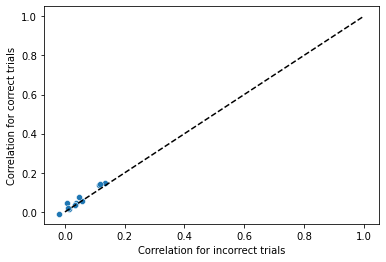

In [42]:
x_correct = tmp[tmp['correct']==True]['corr_median']
y_incorrect = tmp[tmp['correct']==False]['corr_median']
sns.scatterplot(y_incorrect.values, x_correct.values)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Correlation for incorrect trials')
plt.ylabel('Correlation for correct trials')